# Tesla assignment :
"""
Task:
 
Please write an application in any language that calls the USGS API and store the result in a relational database of your choice.
 
https://earthquake.usgs.gov/fdsnws/event/1/
 
1) Please query all events that have occurred during year 2017

2) Read a JSON response from the API

3) Design the database objects required to store the result in a relational fashion.

4) Store the response in those objects

5) Provide query/analysis to give biggest earthquake of 2017

6) Provide query/analysis to give most probable hour of the day for the earthquakes
bucketed by the range of magnitude (0-1,1-2,2-3,3-4,4-5,5-6,>6,
For border values in the bucket, include them in the bucket where the value is a lower limit
so for 1 include it in 1-2 bucket)
 


For question 1-4 provide following:

Code for the integration

DB schema

For question 5 and 6 provide following:

Queries for the analysis

Any interesting visualization (using any open source product or trial version of any product) for these questions. Just attach screenshot.
"""

In [7]:
# import libs
import mysql.connector
import requests
import pandas as pd
from datetime import datetime
import seaborn as sns

In [2]:
# Create request urls for each month.
urls = {}
months = ['01','02','03','04','05','06','07','08','09','10','11']
for month in months:
    start_time = f'2017-{month}-01'
    end_time = f'2017-{str(int(month)+1)}-01'
    date_range = f'starttime=2014-01-01&endtime=2014-01-02'
    urls[f"{start_time} to {end_time}"] = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime={start_time}&endtime={end_time}"

urls[f"2017-12-01 to 2018-01-01"] = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2017-12-01&endtime=2018-01-01"

print(str(urls))

{'2017-01-01 to 2017-2-01': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2017-01-01&endtime=2017-2-01', '2017-02-01 to 2017-3-01': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2017-02-01&endtime=2017-3-01', '2017-03-01 to 2017-4-01': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2017-03-01&endtime=2017-4-01', '2017-04-01 to 2017-5-01': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2017-04-01&endtime=2017-5-01', '2017-05-01 to 2017-6-01': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2017-05-01&endtime=2017-6-01', '2017-06-01 to 2017-7-01': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2017-06-01&endtime=2017-7-01', '2017-07-01 to 2017-8-01': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2017-07-01&endtime=2017-8-01', '2017-08-01 to 2017-9-01': 'https://earthquake.usgs.gov/fdsnws/event

In [3]:
# set up RDBMS with mySql.

mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password=""
)
_DATABASE = "Tesla"
_TABLE = "earthquakes"

cursor = mydb.cursor()
_CREATE_DATABASE = f'''CREATE DATABASE IF NOT EXISTS {_DATABASE}'''
_SELECT_DATABASE = f'''USE {_DATABASE}'''
_COLUMNS = "(event_id, place, mag, time, longitude, latitude, depth)"
_CREATE_TABLE = """CREATE TABLE  IF NOT EXISTS earthquakes ( 
                             id int(11) NOT NULL AUTO_INCREMENT,
                             event_id VARCHAR(20) NOT NULL,
                             place VARCHAR(100),
                             mag FLOAT,
                             time bigint(20) NOT NULL,
                             longitude FLOAT,
                             latitude FLOAT,
                             depth FLOAT,
                             PRIMARY KEY (Id)) """
cursor.execute(_CREATE_DATABASE)
cursor.execute(_SELECT_DATABASE)
cursor.execute(_CREATE_TABLE)


In [4]:
# Send a GET request for each month and 
payload = {}
for date_range, url in urls.items():
    sql = f"INSERT INTO {_TABLE} {_COLUMNS} VALUES (%s, %s, %s, %s, %s, %s, %s)"
    print(f"fetching the data for {date_range}")
    payload = requests.get(url).json()
    val = []
    for feature in payload['features']:
        event_id = feature['id']
        mag = feature['properties']['mag']
        time = feature['properties']['time']
        place = feature['properties']['place']
        coordinates = feature['geometry']['coordinates']
        longitude = coordinates[0]
        latitude = coordinates[1]
        depth = coordinates[2]

        val.append((event_id, place, mag, time, longitude, latitude, depth))

    print(f"loading the data for {date_range}")
    cursor.executemany(sql, val)
    mydb.commit()

    

fetching the data for 2017-01-01 to 2017-2-01
loading the data for 2017-01-01 to 2017-2-01
fetching the data for 2017-02-01 to 2017-3-01
loading the data for 2017-02-01 to 2017-3-01
fetching the data for 2017-03-01 to 2017-4-01
loading the data for 2017-03-01 to 2017-4-01
fetching the data for 2017-04-01 to 2017-5-01
loading the data for 2017-04-01 to 2017-5-01
fetching the data for 2017-05-01 to 2017-6-01
loading the data for 2017-05-01 to 2017-6-01
fetching the data for 2017-06-01 to 2017-7-01
loading the data for 2017-06-01 to 2017-7-01
fetching the data for 2017-07-01 to 2017-8-01
loading the data for 2017-07-01 to 2017-8-01
fetching the data for 2017-08-01 to 2017-9-01
loading the data for 2017-08-01 to 2017-9-01
fetching the data for 2017-09-01 to 2017-10-01
loading the data for 2017-09-01 to 2017-10-01
fetching the data for 2017-10-01 to 2017-11-01
loading the data for 2017-10-01 to 2017-11-01
fetching the data for 2017-11-01 to 2017-12-01
loading the data for 2017-11-01 to 2017

### ANALYSIS

In [17]:
# load back the data from Mysql ( could be a decoupled job )
cursor.execute('SELECT * FROM earthquakes')
table_rows = cursor.fetchall()
df = pd.DataFrame(table_rows, columns=cursor.column_names).set_index('id')

def _convert_epoch_millis(millis):
    hours=(millis/(1000*60*60))%24
    return int(hours)

#  transformstions for the requested data.
filtered_df = df[df.mag.notnull()][df['mag'] >= 0]

filtered_df["rounded_magnitude"] = [f'{int(mag)} - {int(mag)+1}' if mag < 6 else ">6" for mag in filtered_df["mag"]]

filtered_df["hour"] = [_convert_epoch_millis(datetime) for datetime in (filtered_df["time"]/1000)]

/var/folders/bd/1t8hs32d3l723nhyn31sdddw0000gn/T/ipykernel_46884/1612090052.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df[df.mag.notnull()][df['mag'] >= 0]


In [18]:
# query 5:
strongest_earthquake = filtered_df.query('mag == mag.max()').iloc[0]
print("strongest_earthquake")
print(strongest_earthquake)


strongest_earthquake
event_id                                    us2000ahv0
place                near the coast of Chiapas, Mexico
mag                                                8.2
time                                     1504846159180
longitude                                     -93.8993
latitude                                       15.0222
depth                                            47.39
rounded_magnitude                                   >6
hour                                                10
Name: 101515, dtype: object


In [25]:
# query 6:
agg = filtered_df.groupby(['rounded_magnitude', 'hour'])['time'].count().reset_index(name="count")

agg['rank'] = agg.groupby(['rounded_magnitude'])['count'].rank(method='first', ascending=False)
hour_for_earthquakes = agg[agg['rank'] == 1.0]
print("highest probable hour of earth quakes bucketed by the range requested of magnitude:\n")
print(hour_for_earthquakes.head(10))




highest probable hour of earth quakes bucketed by the range requested of magnitude:

   rounded_magnitude  hour  count  rank
4              0 - 1     8   6852   1.0
11             1 - 2     6   6650   1.0
21             2 - 3     7   3008   1.0
30             3 - 4     7    780   1.0
42             4 - 5    10   1574   1.0
52             5 - 6    11    207   1.0
61                >6    11     18   1.0


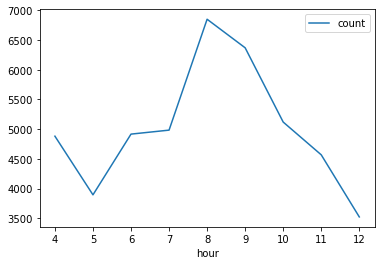

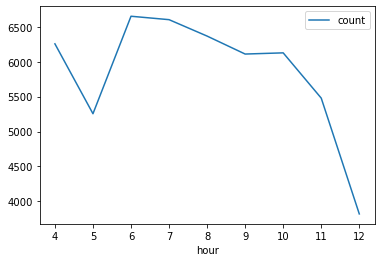

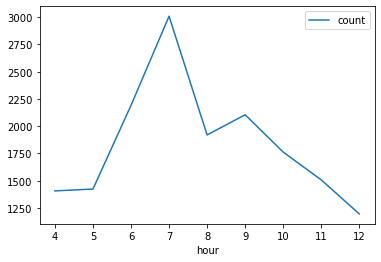

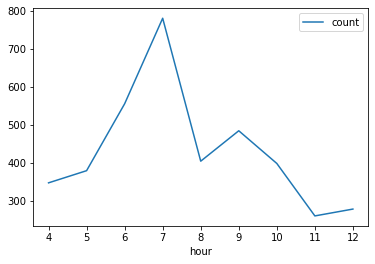

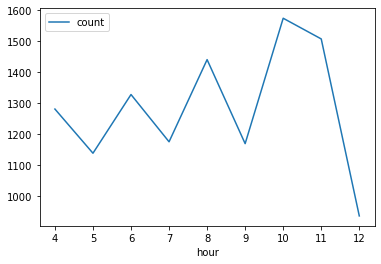

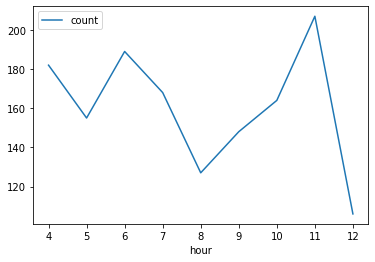

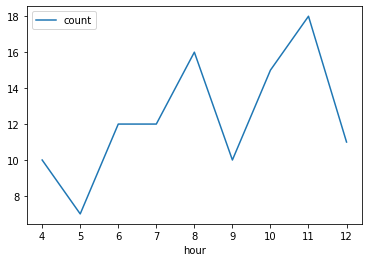

In [30]:
def _build_report(df):
    for mag_range in df['rounded_magnitude'].unique():
        df[df['rounded_magnitude'] == mag_range].plot(x='hour', y='count')
        
_build_report(agg)
    

In [31]:

cm = sns.light_palette("lightgreen", as_cmap=True)
agg.sort_values(by=['rounded_magnitude', 'count']).style.background_gradient(cmap=cm,subset=pd.IndexSlice[:, ['hour']])


,rounded_magnitude,hour,count,rank
8,0 - 1,12,3522,9.000000
1,0 - 1,5,3894,8.000000
7,0 - 1,11,4568,7.000000
0,0 - 1,4,4882,6.000000
2,0 - 1,6,4917,5.000000
3,0 - 1,7,4984,4.000000
6,0 - 1,10,5120,3.000000
5,0 - 1,9,6371,2.000000
4,0 - 1,8,6852,1.000000
17,1 - 2,12,3821,9.000000
